In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from config import mysql_config
import mysql.connector as msql
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [1]:
try:
    conn = msql.connect(host=mysql_config['host'], user=mysql_config['user'], password=mysql_config['password'])
    if conn.is_connected():
        print('connected')
        cursor = conn.cursor()
except msql.Error as err:
    print("Error while connecting to MySQL", err)

connected


In [6]:
sql = """SELECT Fgame_ranking.recomended, Fgame_ranking.playtime, Dgame.pegi_age, Dgame.price, Dgame.achivements, Dgame.avg_playtime, Dgame.pos_rating, Dgame.neg_rating, Fstatistics.avg_players
        FROM Data_storage.Fgame_ranking
        LEFT JOIN Data_storage.Dgame ON Fgame_ranking.idgame = Dgame.idgame
        LEFT JOIN Data_storage.Fstatistics ON Fstatistics.idgame = Dgame.idgame AND Fstatistics.iddate = Fgame_ranking.iddate LIMIT 5000;"""
cursor.execute(sql)
df = pd.DataFrame(cursor.fetchall(), columns=['recomended', 'player_playtime', 'pegi_age', 'price', 'achivements', 'avg_playtime', 'pos_rating', 'neg_rating', 'avg_players'])
df

,recomended,player_playtime,pegi_age,price,achivements,avg_playtime,pos_rating,neg_rating,avg_players
0,0,0,18,28,48,9352,220370,53709,42431.0
1,0,1,18,28,48,9352,220370,53709,42431.0
2,0,2,18,28,48,9352,220370,53709,42431.0
3,0,3,18,28,48,9352,220370,53709,42431.0
4,0,5,18,28,48,9352,220370,53709,42431.0
...,...,...,...,...,...,...,...,...,...
4995,0,703,0,50,50,6512,72029,35294,30445.0
4996,1,0,0,50,50,6512,72029,35294,30445.0
4997,1,1,0,50,50,6512,72029,35294,30445.0
4998,1,2,0,50,50,6512,72029,35294,30445.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recomended       5000 non-null   int64  
 1   player_playtime  5000 non-null   int64  
 2   pegi_age         5000 non-null   int64  
 3   price            5000 non-null   int64  
 4   achivements      5000 non-null   int64  
 5   avg_playtime     5000 non-null   int64  
 6   pos_rating       5000 non-null   int64  
 7   neg_rating       5000 non-null   int64  
 8   avg_players      3687 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 351.7 KB


In [9]:
df['avg_players'] = df['avg_players'].fillna(df['avg_players'].mean())

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recomended       5000 non-null   int64  
 1   player_playtime  5000 non-null   int64  
 2   pegi_age         5000 non-null   int64  
 3   price            5000 non-null   int64  
 4   achivements      5000 non-null   int64  
 5   avg_playtime     5000 non-null   int64  
 6   pos_rating       5000 non-null   int64  
 7   neg_rating       5000 non-null   int64  
 8   avg_players      5000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 351.7 KB


In [20]:
df.describe()

,recomended,player_playtime,pegi_age,price,achivements,avg_playtime,pos_rating,neg_rating,avg_players
count,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,0.710400,-1.132427e-18,-2.259171e-15,1.130296e-15,-5.377898e-15,2.017231e-15,-2.092104e-15,1.314371e-15,1.812084e-15
std,0.453622,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,0.000000,-5.618956e-01,-8.175176e-01,-1.518923e+00,-2.558398e+00,-1.445937e+00,-1.658081e+00,-8.289756e-01,-2.665210e+00
25%,0.000000,-4.866601e-01,-8.175176e-01,-3.465677e-01,-7.429492e-01,-6.348754e-01,-7.715249e-01,-7.108189e-01,-3.983787e-01
50%,1.000000,-3.259296e-01,-8.175176e-01,-5.347893e-02,-4.474110e-01,-1.437826e-01,-1.251460e-01,-5.364944e-01,0.000000e+00
75%,1.000000,7.931639e-02,1.223215e+00,4.421732e-02,6.925220e-01,-7.625217e-02,4.238698e-01,-6.861745e-02,3.584705e-01
max,1.000000,1.901302e+01,1.223215e+00,2.193535e+00,7.616560e+00,1.747906e+00,1.484600e+00,1.832253e+00,1.480022e+00


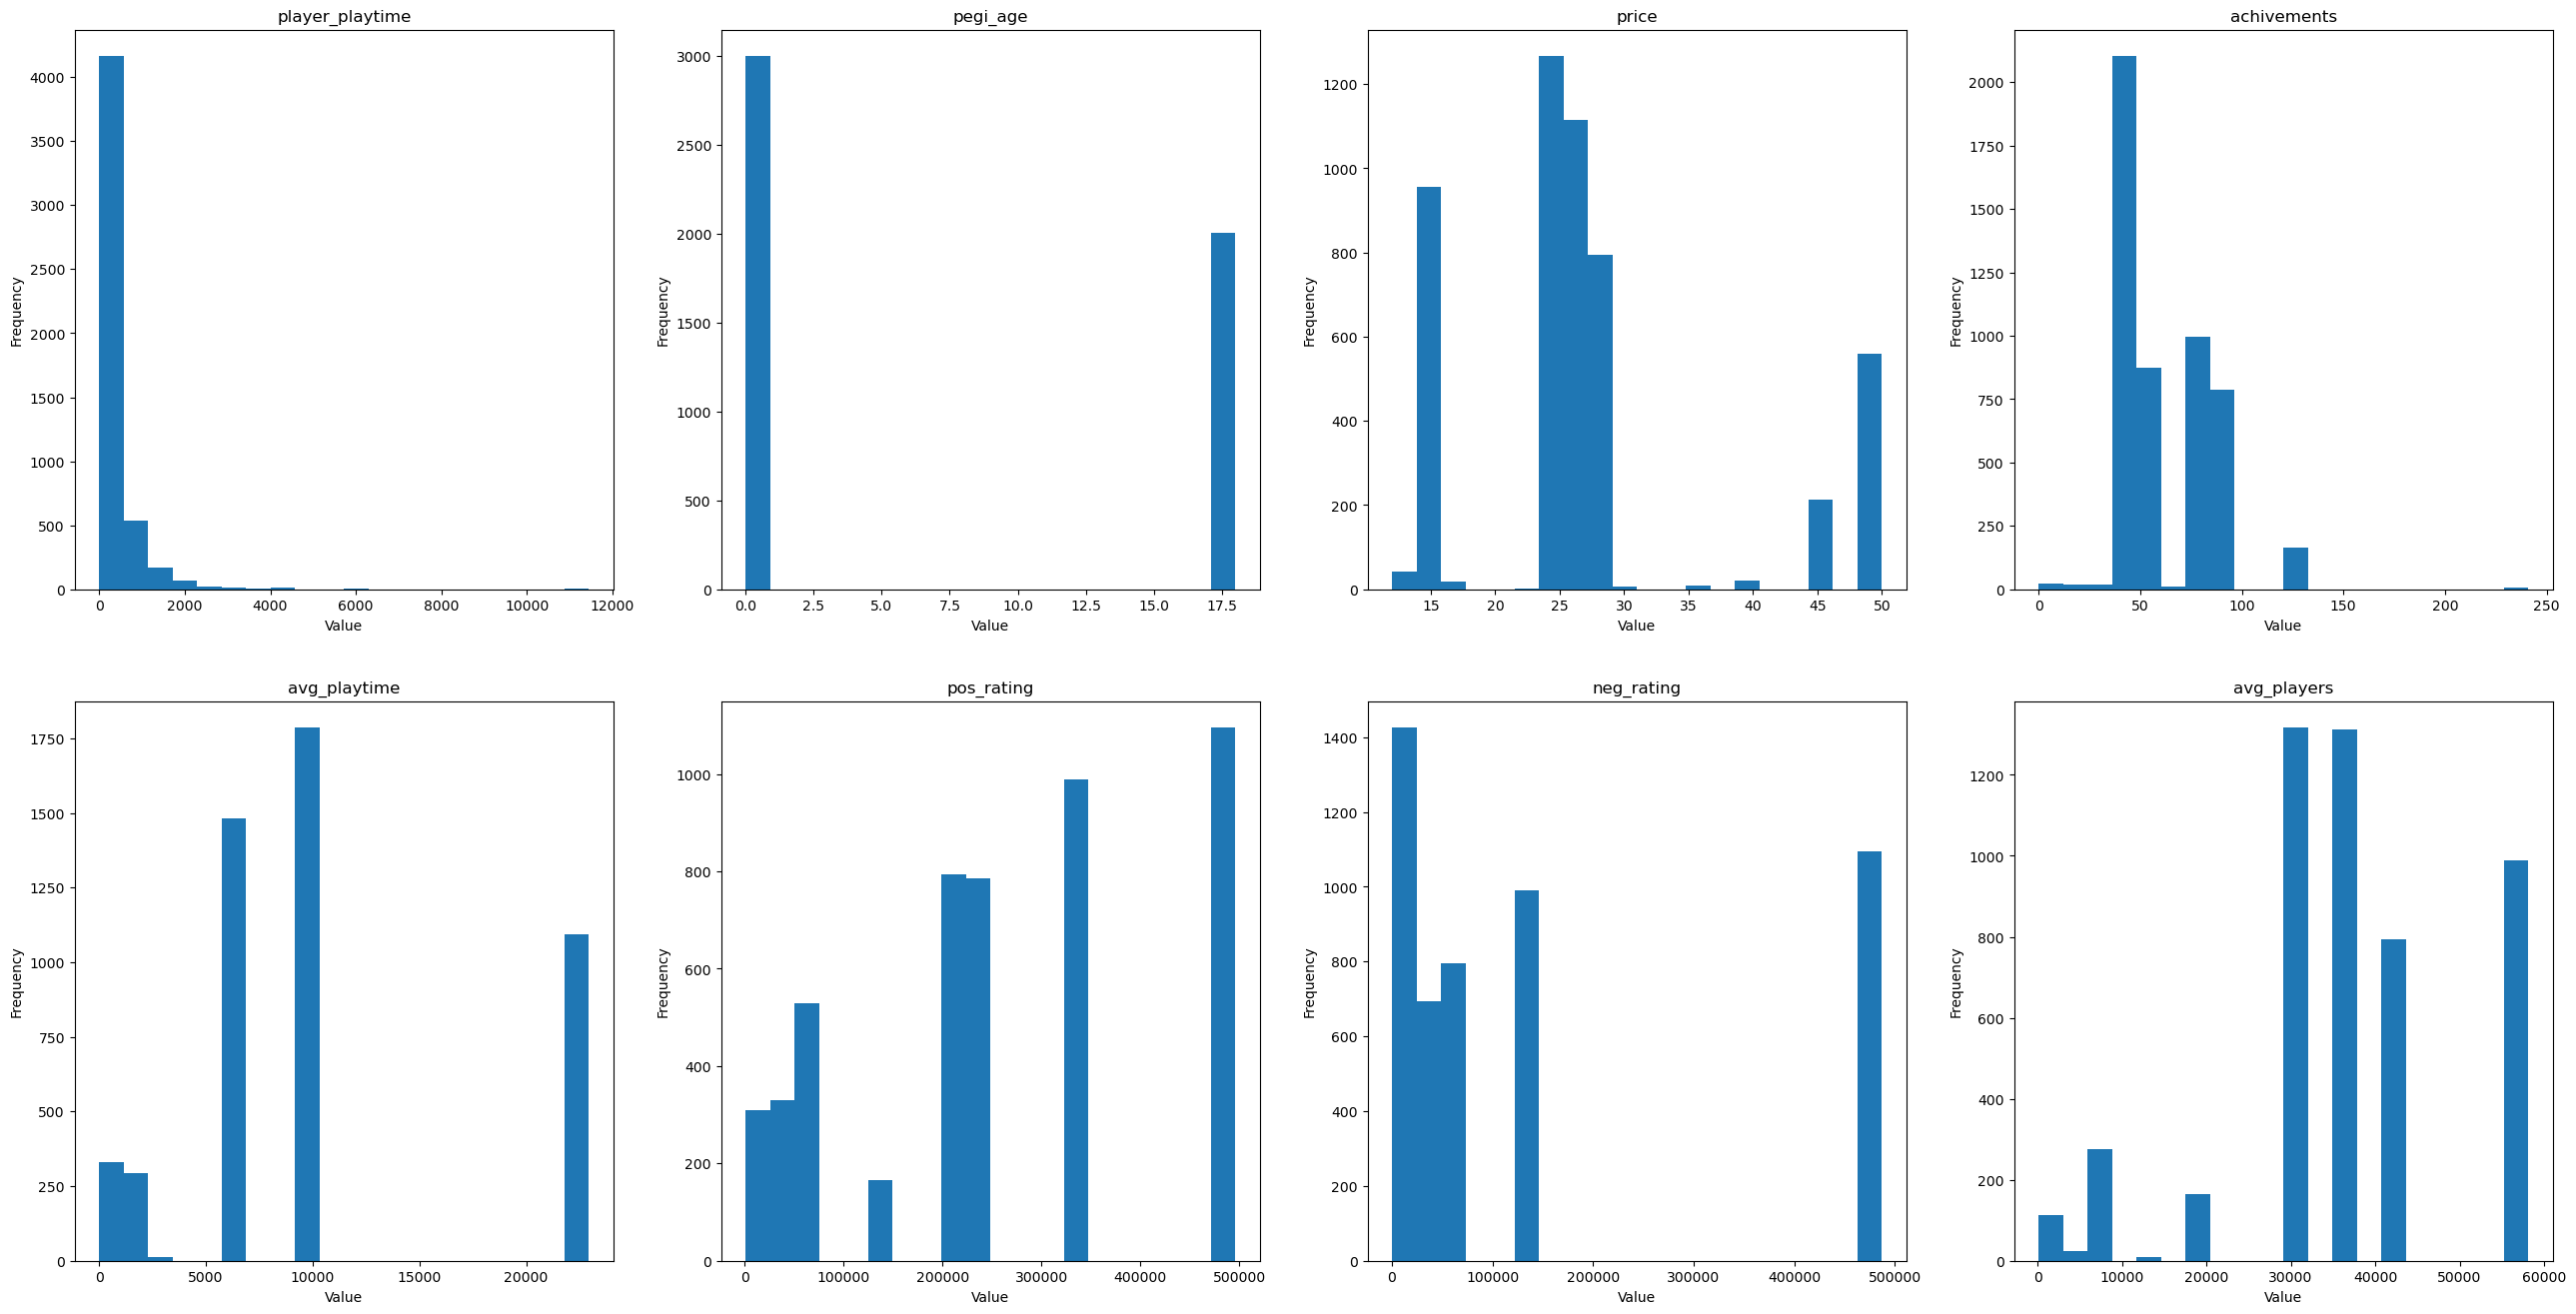

In [17]:
numeric_columns = ['player_playtime', 'pegi_age', 'price', 'achivements', 'avg_playtime', 'pos_rating', 'neg_rating', 'avg_players']
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(32, 16))
for i, col in enumerate(numeric_columns):
    row = i // 4
    j = i % 4
    ax[row][j].hist(df[col], bins=20)
    ax[row][j].set_title(col)
    ax[row][j].set_xlabel('Value')
    ax[row][j].set_ylabel('Frequency')
plt.show()

In [18]:
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('recomended', axis=1), df['recomended'], test_size=0.2, random_state=42)

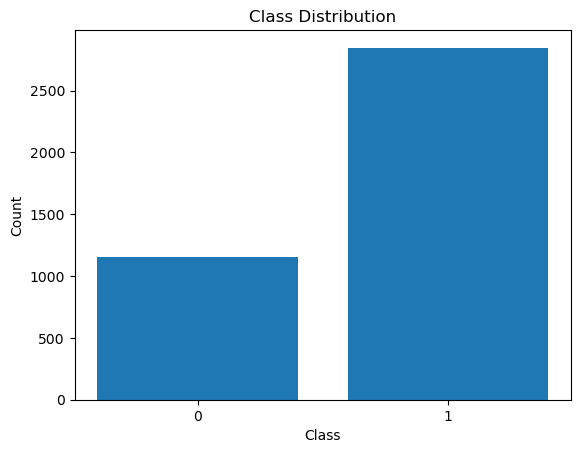

In [25]:
class_counts = y_train.value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1])
plt.show()

In [26]:
train_data = pd.concat([X_train, y_train], axis=1)
class_0 = train_data[train_data['recomended'] == 0]
class_1 = train_data[train_data['recomended'] == 1]
class_0_balanced = resample(class_0, replace=True, n_samples=len(class_1), random_state=42)
balanced_train_data = pd.concat([class_0_balanced, class_1])
X_train = balanced_train_data.drop('recomended', axis=1)
y_train = balanced_train_data['recomended']

In [40]:
logistic_regression = LogisticRegression()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
models = [logistic_regression, decision_tree, random_forest]
for model in models:
    model.fit(X_train, y_train)
    scores = model.score(X_train, y_train)
    print(f"Модель: {model.__class__.__name__}")
    print(f"Середня точність: {scores.mean():.4f}")

Модель: LogisticRegression
Середня точність: 0.6481
Модель: DecisionTreeClassifier
Середня точність: 0.9180
Модель: RandomForestClassifier
Середня точність: 0.9180


Модель: LogisticRegression
Звіт про класифікацію:
              precision    recall  f1-score   support

           0       0.45      0.66      0.53       295
           1       0.82      0.66      0.73       705

    accuracy                           0.66      1000
   macro avg       0.64      0.66      0.63      1000
weighted avg       0.71      0.66      0.67      1000

Модель: DecisionTreeClassifier
Звіт про класифікацію:
              precision    recall  f1-score   support

           0       0.66      0.90      0.76       295
           1       0.95      0.81      0.87       705

    accuracy                           0.83      1000
   macro avg       0.81      0.85      0.82      1000
weighted avg       0.87      0.83      0.84      1000

Модель: RandomForestClassifier
Звіт про класифікацію:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       295
           1       0.94      0.81      0.87       705

    accuracy            

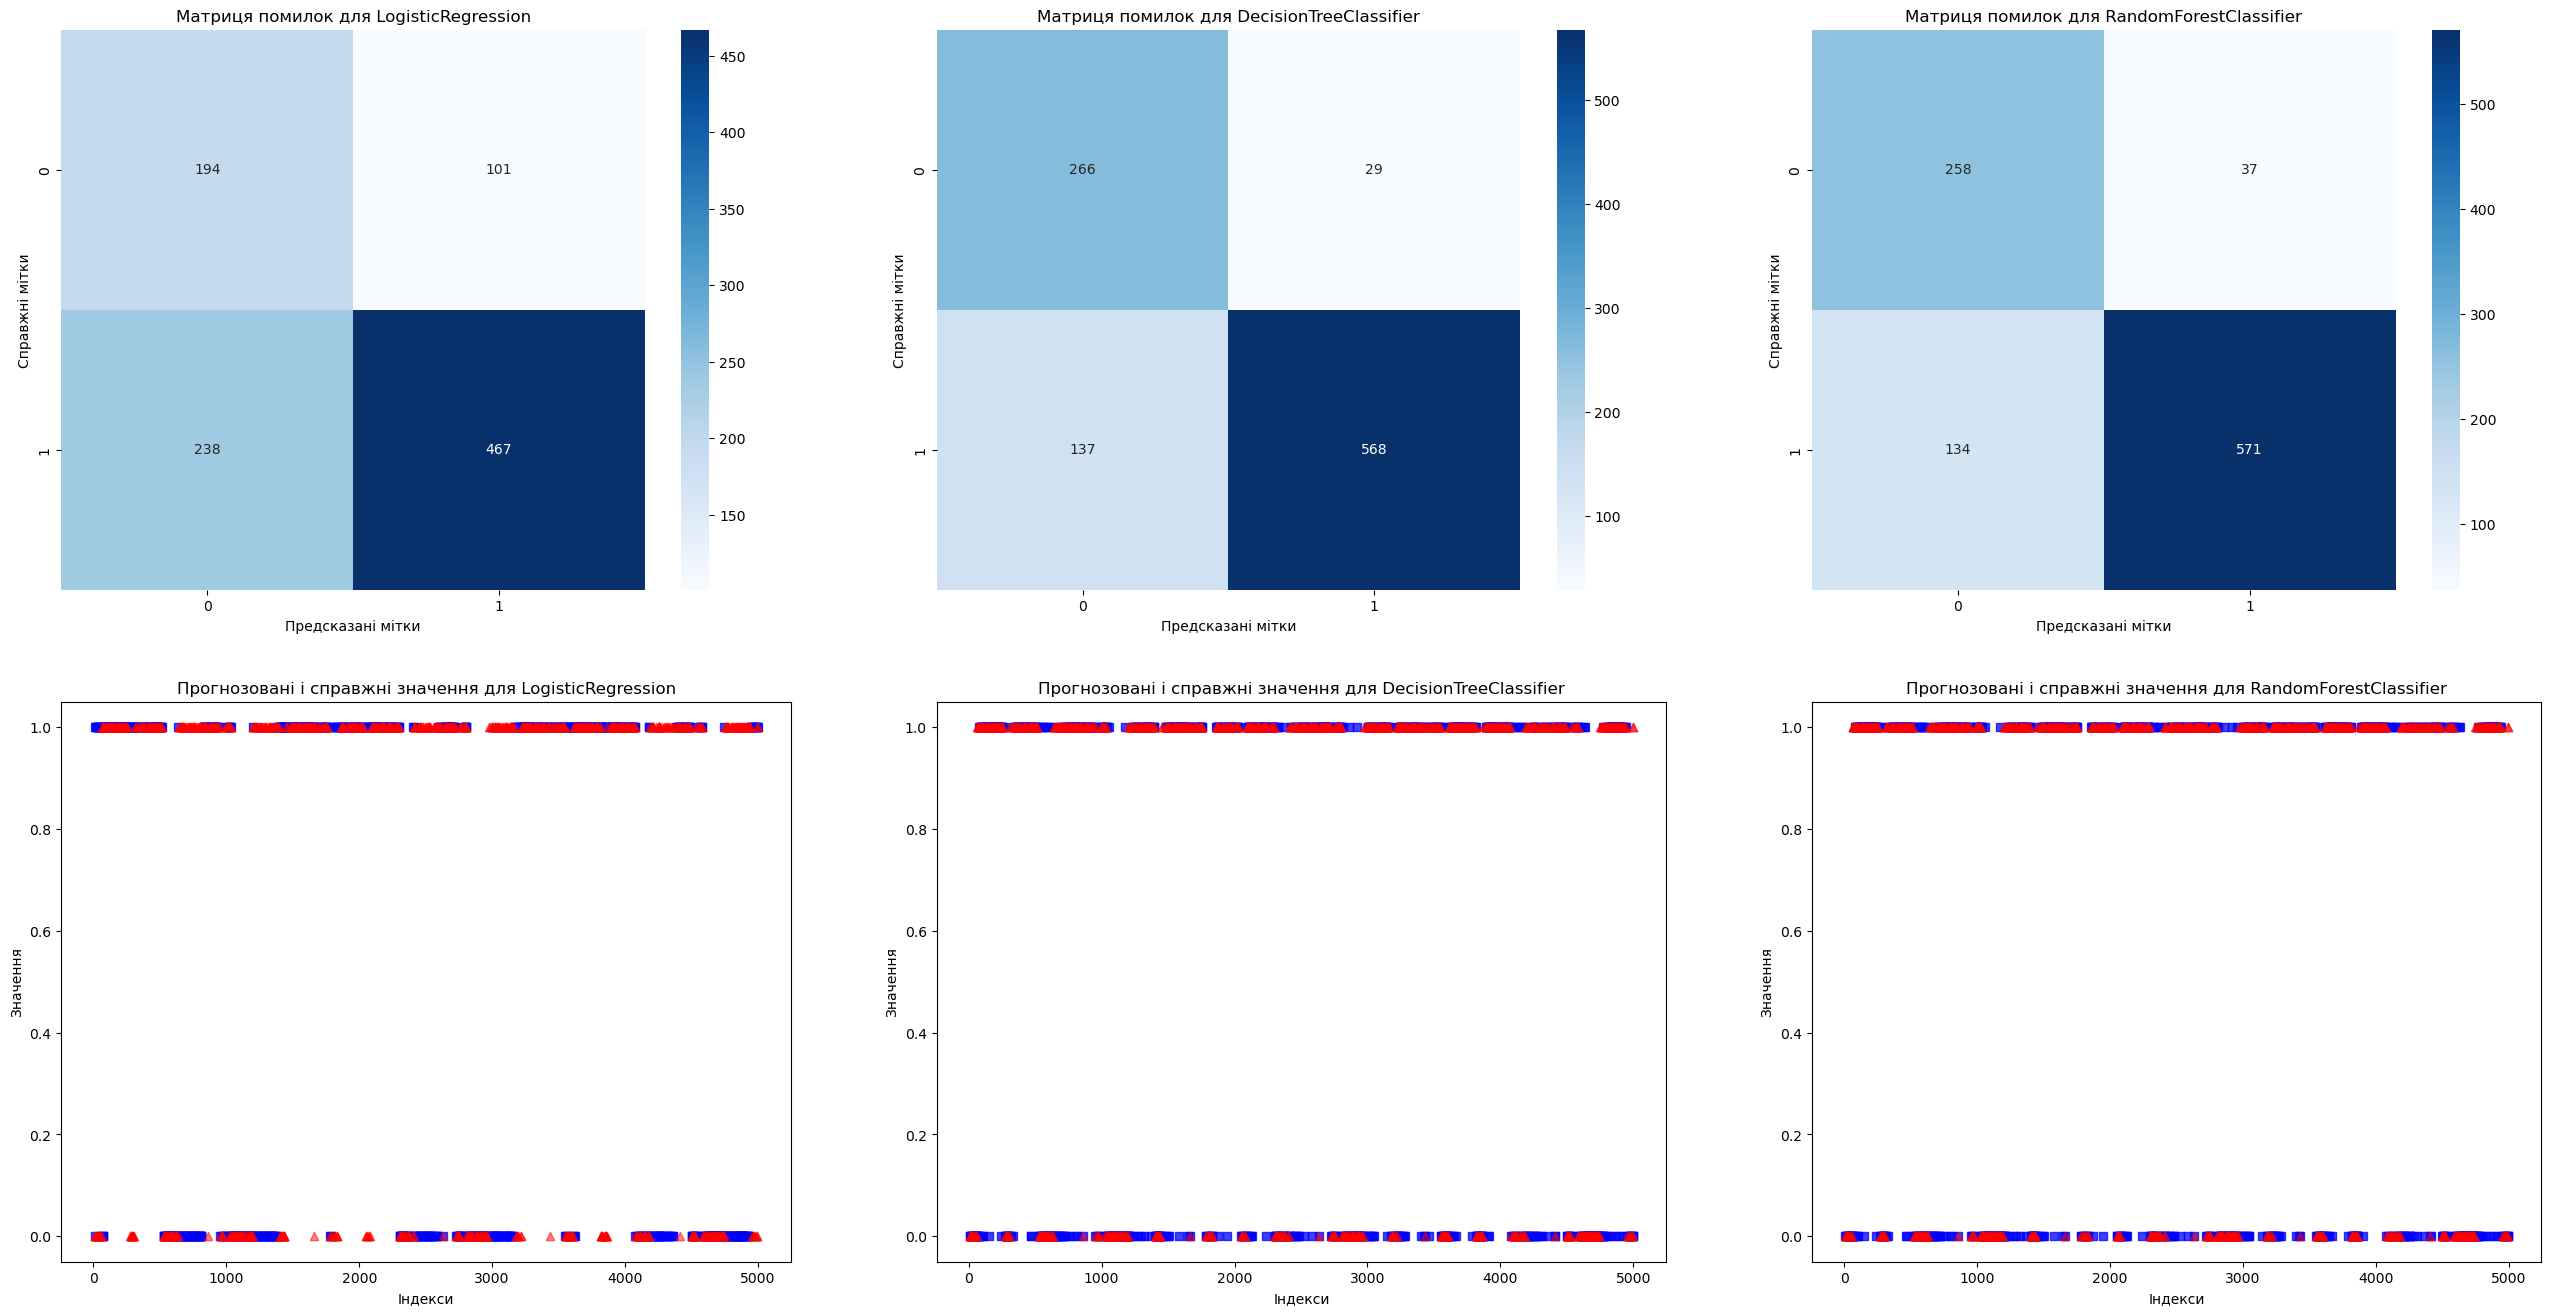

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=len(models), figsize=(32, 16))
for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    confusion_mtx = confusion_matrix(y_test, y_pred)
    class_labels = np.unique(y_test)
    sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=ax[0][i])
    ax[0][i].set_title(f"Матриця помилок для {model.__class__.__name__}")
    ax[0][i].set_xlabel("Предсказані мітки")
    ax[0][i].set_ylabel("Справжні мітки")
    ax[1][i].scatter(X_test.index, y_pred, color='blue', marker='s', alpha=0.75, label='Прогнозовані')
    ax[1][i].scatter(X_test.index, y_test, color='red', marker='^', alpha=0.5, label='Справжні')
    ax[1][i].set_title(f'Прогнозовані і справжні значення для {model.__class__.__name__}')
    ax[1][i].set_xlabel('Індекси')
    ax[1][i].set_ylabel('Значення')
    classification_rep = classification_report(y_test, y_pred)
    print(f"Модель: {model.__class__.__name__}")
    print("Звіт про класифікацію:")
    print(classification_rep)
plt.show()